In [4]:
import torch

In [5]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
import numpy as np
np.random.seed(0)

A = np.array([[0,1,1],[0,1,1],[1,1,0]])

In [10]:
indicies = np.where(A>0)

In [7]:
X = np.random.randn(3,3)
W = np.random.randn(3,2)

In [8]:
X

array([[ 1.76405235,  0.40015721,  0.97873798],
       [ 2.2408932 ,  1.86755799, -0.97727788],
       [ 0.95008842, -0.15135721, -0.10321885]])

In [9]:
W

array([[0.4105985 , 0.14404357],
       [1.45427351, 0.76103773],
       [0.12167502, 0.44386323]])

In [11]:
concat = np.concatenate(((X @ W )[indicies[0]],(X @ W )[indicies[1]]),axis=1)

In [12]:
concat

array([[ 1.42534324,  0.99306094,  3.5171372 ,  1.31029062],
       [ 1.42534324,  0.99306094,  0.15743095, -0.02414947],
       [ 3.5171372 ,  1.31029062,  3.5171372 ,  1.31029062],
       [ 3.5171372 ,  1.31029062,  0.15743095, -0.02414947],
       [ 0.15743095, -0.02414947,  1.42534324,  0.99306094],
       [ 0.15743095, -0.02414947,  3.5171372 ,  1.31029062]])

Now we have got the (hi,hj) pair for i and j adjacency. Now we have to compute the attention based score for each of this pair.

In [13]:
W_atten = np.random.randn(1,4)

In [26]:
atten_score = np.tanh(W_atten@concat.T)

In [27]:
atten_score

array([[ 0.92857604,  0.95787224,  0.99291795,  0.99587921,  0.03490962,
        -0.28664827]])

In [28]:
E= np.zeros((A.shape[0],A.shape[1]))

In [29]:
E[[indicies[0],indicies[1]]] = atten_score[0]  

/tmp/ipykernel_2085423/2156947237.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  E[[indicies[0],indicies[1]]] = atten_score[0]


In [30]:
E

array([[ 0.        ,  0.92857604,  0.95787224],
       [ 0.        ,  0.99291795,  0.99587921],
       [ 0.03490962, -0.28664827,  0.        ]])

In [35]:
def softmax(x):
    return np.exp(x) / np.expand_dims(np.sum(np.exp(x), axis=1),axis=1)

soft_score = softmax(E)

In [36]:
soft_score

array([[0.16294479, 0.41239741, 0.4246578 ],
       [0.15609872, 0.42132589, 0.42257539],
       [0.37164893, 0.26945241, 0.35889866]])

Now we just have to multiply the embedding of the each node with the soft score and the adjacency matrix.

In [1]:
from torch_geometric.datasets import Planetoid  

dataset = Planetoid(root='.', name='Cora')

In [2]:
data = dataset[0]

In [18]:
from torch_geometric.nn import GATConv,GATv2Conv
import torch.nn.functional as F

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(dataset.num_features, 32, heads=8)
        self.conv2 = GATConv(32 * 8, dataset.num_classes, heads=1, concat=False)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.conv1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.conv2(h, edge_index)
        h = F.log_softmax(h, dim=1)
        return h

In [19]:
criteria = torch.nn.CrossEntropyLoss()
model = GAT()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=0.01)

In [20]:
def accuracy(pred,y):
    correct = pred.argmax(dim=1).eq(y).sum().item()
    acc = correct / y.size(0)
    return acc
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x,data.edge_index)
    loss = criteria(out[data.train_mask],data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch%10==0:
        print(loss.item())
        val_loss = criteria(out[data.val_mask],data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask],data.y[data.val_mask])
        print('val_loss:{:.4f},val_acc:{:.4f}'.format(val_loss.item(),val_acc))


1.9426835775375366
val_loss:1.9399,val_acc:0.1400
0.11149610579013824
val_loss:0.8885,val_acc:0.7160
0.21997682750225067
val_loss:0.9941,val_acc:0.6780
0.14469338953495026
val_loss:0.8943,val_acc:0.7080
0.15483419597148895
val_loss:0.8847,val_acc:0.6840
0.14013442397117615
val_loss:0.9121,val_acc:0.7040
0.20295898616313934
val_loss:0.8611,val_acc:0.7280
0.19764918088912964
val_loss:0.8891,val_acc:0.7360
0.16942662000656128
val_loss:0.9486,val_acc:0.7240
0.15907645225524902
val_loss:1.0085,val_acc:0.7080
0.159968301653862
val_loss:0.8701,val_acc:0.7260
0.15351426601409912
val_loss:0.9814,val_acc:0.7120
0.15695273876190186
val_loss:0.8761,val_acc:0.7300
0.17217081785202026
val_loss:0.9363,val_acc:0.7000
0.14058323204517365
val_loss:0.9215,val_acc:0.7100
0.1374574601650238
val_loss:0.9577,val_acc:0.7240
0.2782289683818817
val_loss:0.9906,val_acc:0.7160
0.17753271758556366
val_loss:0.9160,val_acc:0.7020
0.1674230694770813
val_loss:0.9267,val_acc:0.7080
0.16893979907035828
val_loss:0.9424,v

Now let us see how the model fair well with each node degrees.

Text(0.5, 1.0, 'GAT')

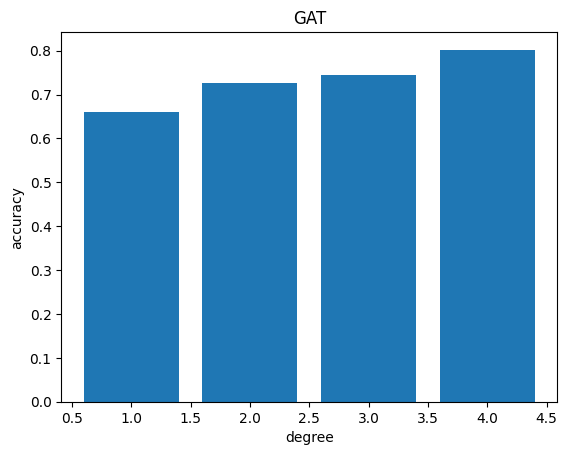

In [26]:
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter
import numpy as np
out = model(data.x,data.edge_index)
degrees = degree(data.edge_index[0]).cpu().numpy()
accuracies = []
for i in range(1,5):
    mask = np.where(degrees==i)[0]
    accuracies.append(accuracy(out[mask],data.y[mask]))
plt.bar(range(1,5),accuracies)
plt.xlabel('degree')
plt.ylabel('accuracy')
plt.title('GAT')

So for higher degrees it performs well. That is the model is able to learn the node embeddings for the nodes with higher degrees. That is all about the Graph Attention Network. Thanks for reading.